In [1]:
# ! pip install transformers
import torch
import numpy as np
import matplotlib.pyplot as plt
from transformers import BertTokenizer
from transformers import BertForSequenceClassification, AdamW

import torchsummary as summary
from tqdm import tqdm

from torch.utils.data import DataLoader
from torch.nn import CrossEntropyLoss
from torch.optim import Adam
from torch import nn
import torch.nn.functional as F
from transformers import BertModel
from transformers import BertTokenizer

from sklearn.model_selection import train_test_split
import torch

import pandas as pd
import numpy as np
import os
import base64
import gc
import glob, os

from torch.optim import Adam
from tqdm import tqdm

import warnings
warnings.filterwarnings("ignore")

import json
import sys
sys.path.append("..")
from reghub_pack.general_functions import *

C:\Users\hp\miniconda3\envs\tf_gpu\lib\site-packages\scipy\__init__.py:132: UserWarning: A NumPy version >=1.21.6 and <1.28.0 is required for this version of SciPy (detected version 1.20.0)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# Import data
# Access aws credentials from json file
with open("../aws_credentials.json", 'r') as file:
    aws_creds_json = json.load(file)
# Specify s3 bucket
bucket = "fs-reghub-news-analysis"

# Connect to aws and dowload the files
aws = awsOps(aws_creds_json)
df = aws.get_df(bucket=bucket, file="data_rule_labels_v1.csv")
df_categories = aws.get_df(bucket=bucket, file="rule_labels_v1.csv")

In [3]:
df.drop('Unnamed: 0',axis=1,inplace=True)
df=df[['news_content','rule_labels_comb']]
df=df[~df['rule_labels_comb'].isna()]
df=df[(df['rule_labels_comb'].apply(len)!=2)]
df = df.reset_index()
del df['index']

In [4]:
from ast import literal_eval
df['rule_labels_comb'] = df['rule_labels_comb'].apply(literal_eval)
df['target']='[0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0]'
df['target'] = df['target'].apply(literal_eval)

df['target'].iloc[0][0]

0.0

In [5]:
for index, value in df['rule_labels_comb'].iteritems():
    class_dic={'legal':0,'sanctions':1,'papers':2,'reports':3,'statements':4,'guidelines':5,'press':6,'personnel':7,'market':8}
    val=[class_dic.get(i, i) for i in value]
    df['rule_labels_comb'].iloc[index]=val
    y=0
    for x in df['rule_labels_comb'].iloc[index]:
        df['target'].iloc[index][x]=1.0
        y=y+1
df['rule_labels_comb']

0                [8]
1                [8]
2                [8]
3             [2, 8]
4          [1, 2, 8]
            ...     
5517       [0, 4, 5]
5518          [3, 7]
5519       [0, 3, 8]
5520    [0, 3, 5, 6]
5521    [0, 3, 4, 6]
Name: rule_labels_comb, Length: 5522, dtype: object

In [6]:
df['target']

0       [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]
1       [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]
2       [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]
3       [0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]
4       [0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]
                            ...                      
5517    [1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0]
5518    [0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0]
5519    [1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0]
5520    [1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0]
5521    [1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0]
Name: target, Length: 5522, dtype: object

In [7]:
# change range of labels, minimum should be zero
df['rule_labels_comb']=df['rule_labels_comb'].astype(str)
df

,news_content,rule_labels_comb,target
0,Berenberg Bank analysts have provided a buy ra...,[8],"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]"
1,"The article states that Berenberg, a German in...",[8],"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]"
2,"In their analysis on October 30, 2023, experts...",[8],"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]"
3,The private bank Berenberg has upgraded its ra...,"[2, 8]","[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]"
4,In a research note published by Sebastian Bray...,"[1, 2, 8]","[0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]"
...,...,...,...
5517,INTERVIEW Interview with Les Échos Interview w...,"[0, 4, 5]","[1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0]"
5518,UBS's latest Investor Watch report reveals tha...,"[3, 7]","[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0]"
5519,SNB erwartet für 2021 Jahresgewinn von rund 26...,"[0, 3, 8]","[1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0]"
5520,0:00 News A cryptocurrency exchange in Hong Ko...,"[0, 3, 5, 6]","[1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0]"


In [8]:
# additional filtering to balance classes
'''
df_3=df[(df['result']==3) & (df['content'].str.len()<350)]
df=df[~(df['result']==3)]
df=pd.concat([df,df_3])
df
'''

"\ndf_3=df[(df['result']==3) & (df['content'].str.len()<350)]\ndf=df[~(df['result']==3)]\ndf=pd.concat([df,df_3])\ndf\n"

In [9]:
# train test split
X_train, X_test= train_test_split(df[['news_content','target']], test_size=0.25)

In [10]:
df_train=X_train
df_val=X_test
df_test=0

In [11]:
df_train

,news_content,target
4327,https:bit.ly3zFSy4Y BOE GUIDES RATE EXPECTATIO...,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0]"
2483,The article discusses the recent surge in Appl...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]"
2860,On May 21 2023 the financial world was abuzz w...,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0]"
3782,EY Deutschland plant mit Kündigungen in dreist...,"[1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0]"
569,The article mentions that Julius Baer analyst ...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]"
...,...,...
2603,In den vergangenen sechs Monaten kÃnnen sich C...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]"
2668,The article discusses the overvaluation of the...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]"
1607,The article discusses an investment advisor jo...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0]"
1366,The article discusses the neutral position mai...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]"


In [12]:
df_train=df_train.reset_index()
df_train.drop('index',axis=1,inplace=True)

df_val=df_val.reset_index()
df_val.drop('index',axis=1,inplace=True)
df_val

,news_content,target
0,"Fabian Strebin vom Anlegermagazin ""Der Aktionä...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]"
1,"Julius Baer, a Swiss private banking group, ha...","[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0]"
2,UBS partnered with 43OakFoundation UBSArena an...,"[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
3,Commerzbank has started its announced share bu...,"[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0]"
4,Handeln für die Ukraine: Trading Charity an de...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]"
...,...,...
1376,The article states that low interest rates hav...,"[0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0]"
1377,"Oddo BHF, a French-German financial services g...","[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0]"
1378,UHNWIs investieren im Gegensatz zu vielen and...,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
1379,"According to an article, the Swiss financial r...","[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]"


In [13]:
# change datatypes of input data
df_train['news_content']=df_train['news_content'].astype(str)

df_val['news_content']=df_val['news_content'].astype(str)
df_train['news_content'].iloc[0]
train_data=df_train
val_data=df_val

In [15]:
torch.cuda.empty_cache()
gc.collect()

0

In [16]:
import sys
sys.path.append("..")
# Add the parent directory to the Python path
from reghub_pack.models import BERT_RegHub

Under Maintenance
Under Maintenance


Epoch 1/100: 100%|██████████████████████████| 130/130 [07:10<00:00,  3.31s/item, acc=0.769, loss=0.283, true_acc=0.795]


Epoch 2/100: 100%|██████████████████████████| 130/130 [07:12<00:00,  3.32s/item, acc=0.769, loss=0.275, true_acc=0.812]


Epoch 3/100: 100%|██████████████████████████| 130/130 [07:11<00:00,  3.32s/item, acc=0.846, loss=0.257, true_acc=0.829]


Epoch 4/100: 100%|██████████████████████████| 130/130 [07:10<00:00,  3.31s/item, acc=0.769, loss=0.256, true_acc=0.838]


Epoch 5/100: 100%|██████████████████████████████| 130/130 [07:09<00:00,  3.30s/item, acc=1, loss=0.229, true_acc=0.846]


Epoch 6/100: 100%|██████████████████████████| 130/130 [07:09<00:00,  3.31s/item, acc=0.923, loss=0.226, true_acc=0.821]


Epoch 7/100: 100%|██████████████████████████████| 130/130 [07:10<00:00,  3.31s/item, acc=1, loss=0.217, true_acc=0.863]


Epoch 8/100: 100%|████████████████████████████████| 130/130 [07:09<00:00,  3.30s/item, acc=1, loss=0.21, true_acc=0.88]


Epoch 9/100: 100%|██████████████████████████████| 130/130 [07:09<00:00,  3.31s/item, acc=1, loss=0.204, true_acc=0.872]


Epoch 10/100: 100%|█████████████████████████████| 130/130 [07:09<00:00,  3.30s/item, acc=1, loss=0.202, true_acc=0.863]


Epoch 11/100: 100%|█████████████████████████████| 130/130 [07:09<00:00,  3.31s/item, acc=1, loss=0.194, true_acc=0.846]


Epoch 12/100: 100%|█████████████████████████████| 130/130 [07:09<00:00,  3.30s/item, acc=1, loss=0.192, true_acc=0.872]


Epoch 13/100: 100%|█████████████████████████████| 130/130 [07:09<00:00,  3.31s/item, acc=1, loss=0.188, true_acc=0.872]


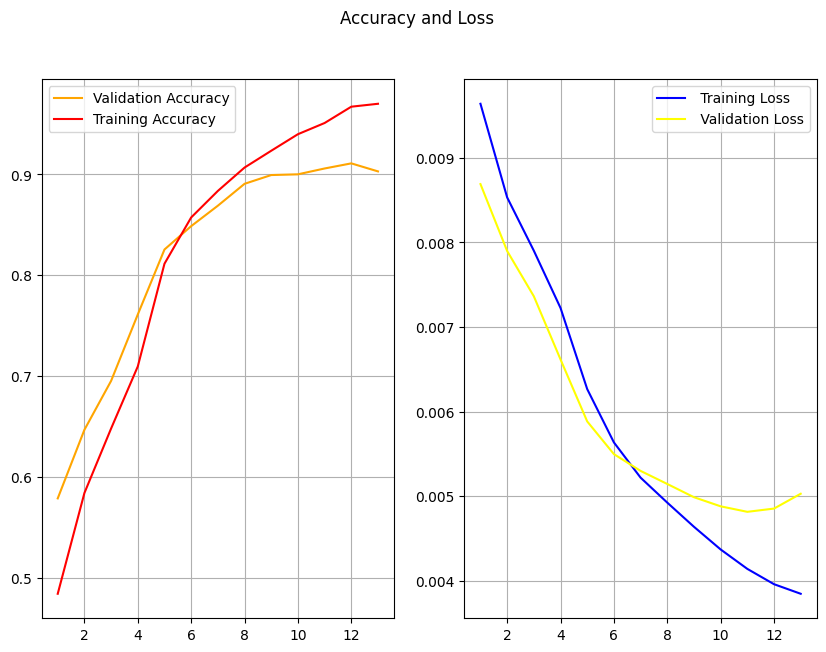

In [17]:
model=BERT_RegHub()
model.model_training(train_data=train_data, val_data=val_data)
model.metrics_graph()

In [18]:
model.save_best_model(save_aws=True)

In [20]:
model.classifier(input_text="Commerzbank will have to hold a little more capital in the future at the behest of the European Central Bank. The institution-specific capital requirement for Pillar 2 will increase from 2.0 to 2.25 percent of total capital in 2024, the DAX group announced on Friday evening in Frankfurt. According to the information, the bank will have to cover 1.27 instead of 1.13 percent of this with common equity core capital. Based on these requirements, the group had to pro forma cover 10.27 percent of its risk-weighted assets with common equity Tier 1 capital at the end of September. In fact, their so-called CET-1 ratio was significantly higher at 14.6 percent.")

legal 0.409539133310318 %
sanctions 0.09926992654800415 %
papers 0.09926992654800415 %
reports 0.17790229618549347 %
statements 98.08895874023438 %
guidelines 0.24026250839233398 %
press 0.31675535440444946 %
personnel 0.09926992654800415 %
market 0.46876803040504456 %


In [28]:
model.classifier(input_text="The economy in Europe is deteriorating and inflation has recently fallen sharply from 2.9% to 2.4% (target 2.0%). As with the failure to recognize inflation in 2022, the ECB does not want to be caught off guard again in 2022 and this time prefers to play it safe in the fight against inflation. Would you rather keep interest rates higher for longer? And so the markets expect key interest rates to be cut sooner than the ECB. The ECB will cut interest rates as early as April 2024, not in June as previously expected, according to economists at Deutsche Bank.")

legal 11.759008407592773 %
sanctions 0.8462705612182617 %
papers 0.6659176349639893 %
reports 0.6659176349639893 %
statements 1.3181743621826172 %
guidelines 10.94904613494873 %
press 0.7741797566413879 %
personnel 0.8819068670272827 %
market 72.13957977294922 %


In [29]:
model.classifier(input_text="Deutsche Bank expects the ECB to cut interest rates quickly and sharply from spring 2024. When the European Central Bank (ECB) and the US Fed meet next week for their final meetings of the year, the focus will be less on interest rate decisions. It seems all too clear that both central banks will leave their key interest rates unchanged at a high level. However, the markets will pay even closer attention to the outlook given by ECB boss Christine Lagarde and Fed boss Jerome Powell - and whether this gives any indication as to when the central banks could lower their key interest rates again.")

legal 5.127647876739502 %
sanctions 1.874603271484375 %
papers 1.7629454135894775 %
reports 2.5183794498443604 %
statements 1.7629454135894775 %
guidelines 39.301536560058594 %
press 3.8748831748962402 %
personnel 1.7629454135894775 %
market 42.01411056518555 %
